# **주요 내용**
kernel 수를 128 * 4에서 16, 32, 64, 128로 변경

In [0]:
import tensorflow as tf
tf.__version__

'2.2.0-rc2'

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7900152114361577026, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 130035182767323107
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8618763708042628576
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15701463552
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4617643966085427568
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [0]:
import platform
platform.platform()

'Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic'

In [0]:
!nvidia-smi

Tue Apr  7 16:19:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    34W / 250W |    353MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**파일 압축 해제 (드라이브에는 *.zip 파일 형식으로 저장되어 있음)**

In [0]:
import os

pcm_path = "./pcm_dataset"
wav_path = "./wav_dataset"

# mkdir
if not os.path.exists(pcm_path):
    os.mkdir(pcm_path)

if not os.path.exists(wav_path):
    os.mkdir(wav_path)

# unzip with quite mode (-q options)
!unzip -q "/content/drive/My Drive/ETRI/9_voice_download_4_Korean_English_by_Korean_part2.zip" -d "./pcm_dataset"

print(os.listdir(pcm_path)[:5])
print(len(os.listdir(pcm_path)))

['I4F07633JSI0', 'I4F07443LJA0', 'GSM09752SCY0', 'GSF04524CJI0', 'GSF08142LDH0']
50


***.pcm to *.wav**

In [0]:
import wave

for i, folder_path in enumerate(sorted(os.listdir(pcm_path))): # sorted!!!
    file_list = os.listdir(os.path.join(pcm_path, folder_path)) # label's path
    file_list_pcm = [files for files in file_list if files.endswith(".pcm")] # *.pcm files

    for j, file_path in enumerate(sorted(file_list_pcm)): # sorted!!!
        with open(os.path.join(pcm_path, folder_path, file_path), "rb") as pcm_file:
            pcm_data = pcm_file.read()
        # save as {label}_{features}.wav format
        with wave.open(os.path.join(wav_path, "{}_{}.wav".format(i, j)), 'wb') as wav_file:
            wav_file.setparams((1, 2, 16000, 0, 'NONE', 'NONE')) # 16kHz, mono channel
            wav_file.writeframes(pcm_data)

# print samples
print(os.listdir(wav_path)[:5])
print(len(os.listdir(wav_path)))

['0_17.wav', '11_3.wav', '12_15.wav', '25_39.wav', '23_90.wav']
5000


In [0]:
import numpy as np

num_labels = 50
num_features = 100
data_length = 3 ** 9
# sr = 16000
# duration = 1

train_rate = 0.8
num_train_data = int(num_features * train_rate) # 80

select_train_data = [True] * num_train_data + [False] * (num_features - num_train_data)
select_test_data = [False] * num_train_data + [True] * (num_features - num_train_data)

# naming
save_train_data_name = 'train_data'
save_train_labels_name = 'train_labels'

save_test_data_name = 'test_data'
save_test_labels_name = 'test_labels'

**train data, test data로 구분하여 numpy 저장 (*.npz)**

In [0]:
# save features as *.npz format

from scipy.io import wavfile

data = np.zeros((num_labels * num_features, data_length))
labels = np.zeros((num_labels * num_features))

for i in range(num_labels):
    for j in range(num_features):
        file_name = "{}_{}.wav".format(i, j)
        sample_rate, samples = wavfile.read(os.path.join(wav_path, file_name))
        
        # start = int(len(samples)//2 - duration * sample_rate / 2)
        # end = int(len(samples)//2 + duration * sample_rate / 2)

        start = int(len(samples) - data_length) // 2
        end = start + data_length
        
        data[i * num_features + j] = samples[start:end]
        labels[i * num_features + j] = i

train_data = data[select_train_data * num_labels]
train_labels = labels[select_train_data * num_labels]

test_data = data[select_test_data * num_labels]
test_labels = labels[select_test_data * num_labels]

# save *.npy        
np.save("./" + save_train_data_name, train_data)
np.save("./" + save_train_labels_name, train_labels)

np.save("./" + save_test_data_name, test_data)
np.save("./" + save_test_labels_name, test_labels)

print("train_data.shape: {}, train_labels.shape: {}".format(train_data.shape, train_labels.shape))
print("test_data.shape: {}, test_labels.shape: {}".format(test_data.shape, test_labels.shape))

train_data.shape: (4000, 19683), train_labels.shape: (4000,)
test_data.shape: (1000, 19683), test_labels.shape: (1000,)


**train data, validation data 분할 및 전처리 (normalization)**

In [0]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

random_state = 1234
test_size = 0.2

X_train, X_val, Y_train, Y_val = train_test_split(train_data, train_labels,
                                                  test_size = test_size,
                                                  random_state = random_state) # fixed

x_train = X_train.reshape(len(X_train), data_length, 1)
x_val = X_val.reshape(len(X_val), data_length, 1) 

y_train = to_categorical(Y_train)
y_val = to_categorical(Y_val)

# standarization
mean = x_train.mean()
x_train -= mean
std = x_train.std()
x_train /= std

x_val -= mean
x_val /= std 

print("test_size: {}, random_state: {}\n".format(test_size, random_state))
print('x_train.shape: {}, y_train.shape: {}'.format(x_train.shape, y_train.shape))
print('x_val.shape: {}, y_val.shape: {}'.format(x_val.shape, y_val.shape))

test_size: 0.2, random_state: 1234

x_train.shape: (3200, 19683, 1), y_train.shape: (3200, 50)
x_val.shape: (800, 19683, 1), y_val.shape: (800, 50)


**Build Model (pre-emphasis 적용 x)**

In [0]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

model = Sequential()

# pre-emphasis
# model.add(layers.Conv1D(filters = data_length, kernel_size = 2, strides = 1, 
#                         padding = "same", activation = 'relu', input_shape = (data_length, 1)))
# model.add(layers.MaxPooling1D(3))
# model.add(layers.BatchNormalization())

# convolutional layer (4 blocks)
model.add(layers.Conv1D(filters = 16, kernel_size = 3, strides = 1, 
                        padding = "same", activation = 'relu', input_shape = (data_length, 1)))
model.add(layers.MaxPooling1D(3))
model.add(layers.BatchNormalization())

model.add(layers.Conv1D(filters = 32, kernel_size = 3, strides = 1,
                        padding = "same", activation = 'relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.BatchNormalization())

model.add(layers.Conv1D(filters = 64, kernel_size = 3, strides = 1,
                        padding = "same", activation = 'relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.BatchNormalization())

model.add(layers.Conv1D(filters = 128, kernel_size = 3, strides = 1,
                        padding = "same", activation = 'relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.BatchNormalization())

# mapping from (3**5, 128) to (128) by GlobalAveragePooling1D()
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(num_labels, activation = 'softmax'))

model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()
# plot_model(model, show_shapes = True, to_file = 'model.png')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 19683, 16)         64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6561, 16)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6561, 16)          64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6561, 32)          1568      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2187, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2187, 32)          128       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2187, 64)          6

**첫 번째 convolutional layer인 pre-emphasis layer의 가중치 초기값 설정**

In [0]:
# weight = np.zeros((2, 1, data_length))

**모델 훈련 및 저장**

In [0]:
from datetime import datetime

batch_size = 80
epochs = 100

history = model.fit(x_train, y_train,
                    validation_data = (x_val, y_val),
                    epochs = epochs,
                    batch_size = batch_size,
                    verbose = 1)

Epoch 1/100
40/40 [==============================] - 2s 38ms/step - loss: 0.7651 - accuracy: 0.8737 - val_loss: 3.9686 - val_accuracy: 0.0750
Epoch 2/100
40/40 [==============================] - 2s 39ms/step - loss: 0.6540 - accuracy: 0.8884 - val_loss: 3.6147 - val_accuracy: 0.1425
Epoch 3/100
40/40 [==============================] - 2s 38ms/step - loss: 0.5622 - accuracy: 0.9087 - val_loss: 3.2228 - val_accuracy: 0.2262
Epoch 4/100
40/40 [==============================] - 1s 37ms/step - loss: 0.4965 - accuracy: 0.9153 - val_loss: 2.5939 - val_accuracy: 0.3375
Epoch 5/100
40/40 [==============================] - 1s 37ms/step - loss: 0.4343 - accuracy: 0.9284 - val_loss: 2.1115 - val_accuracy: 0.4013
Epoch 6/100
40/40 [==============================] - 1s 37ms/step - loss: 0.3939 - accuracy: 0.9316 - val_loss: 1.9076 - val_accuracy: 0.4875
Epoch 7/100
40/40 [==============================] - 2s 38ms/step - loss: 0.3472 - accuracy: 0.9375 - val_loss: 1.4171 - val_accuracy: 0.5612
Epoch 

**모델 및 결과 저장**

In [0]:
def history_to_numpy(history):
    title = list(history.history.keys())
    history_npy = np.array(title + [history.history[t] for t in title])

    return history_npy

save_model_path = "/content/drive/My Drive/models" # save to my drive
if not os.path.exists(save_model_path):
    os.mkdir(save_model_path)

save_results_path = "/content/drive/My Drive/results"
if not os.path.exists(save_results_path):
    os.mkdir(save_results_path)

save_file_name = "{}".format(datetime.today().strftime("%Y_%m_%d_%H_%M_%S"))
model.save(os.path.join(save_model_path, "{}.h5".format(save_file_name)))
np.save(os.path.join(save_model_path, "{}.npy".format(save_file_name)), history_to_numpy(history))

# name
print("save_file_name: {}".format(save_file_name))

save_file_name: 2020_04_07_16_26_03


**히스토리 출력**

In [0]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


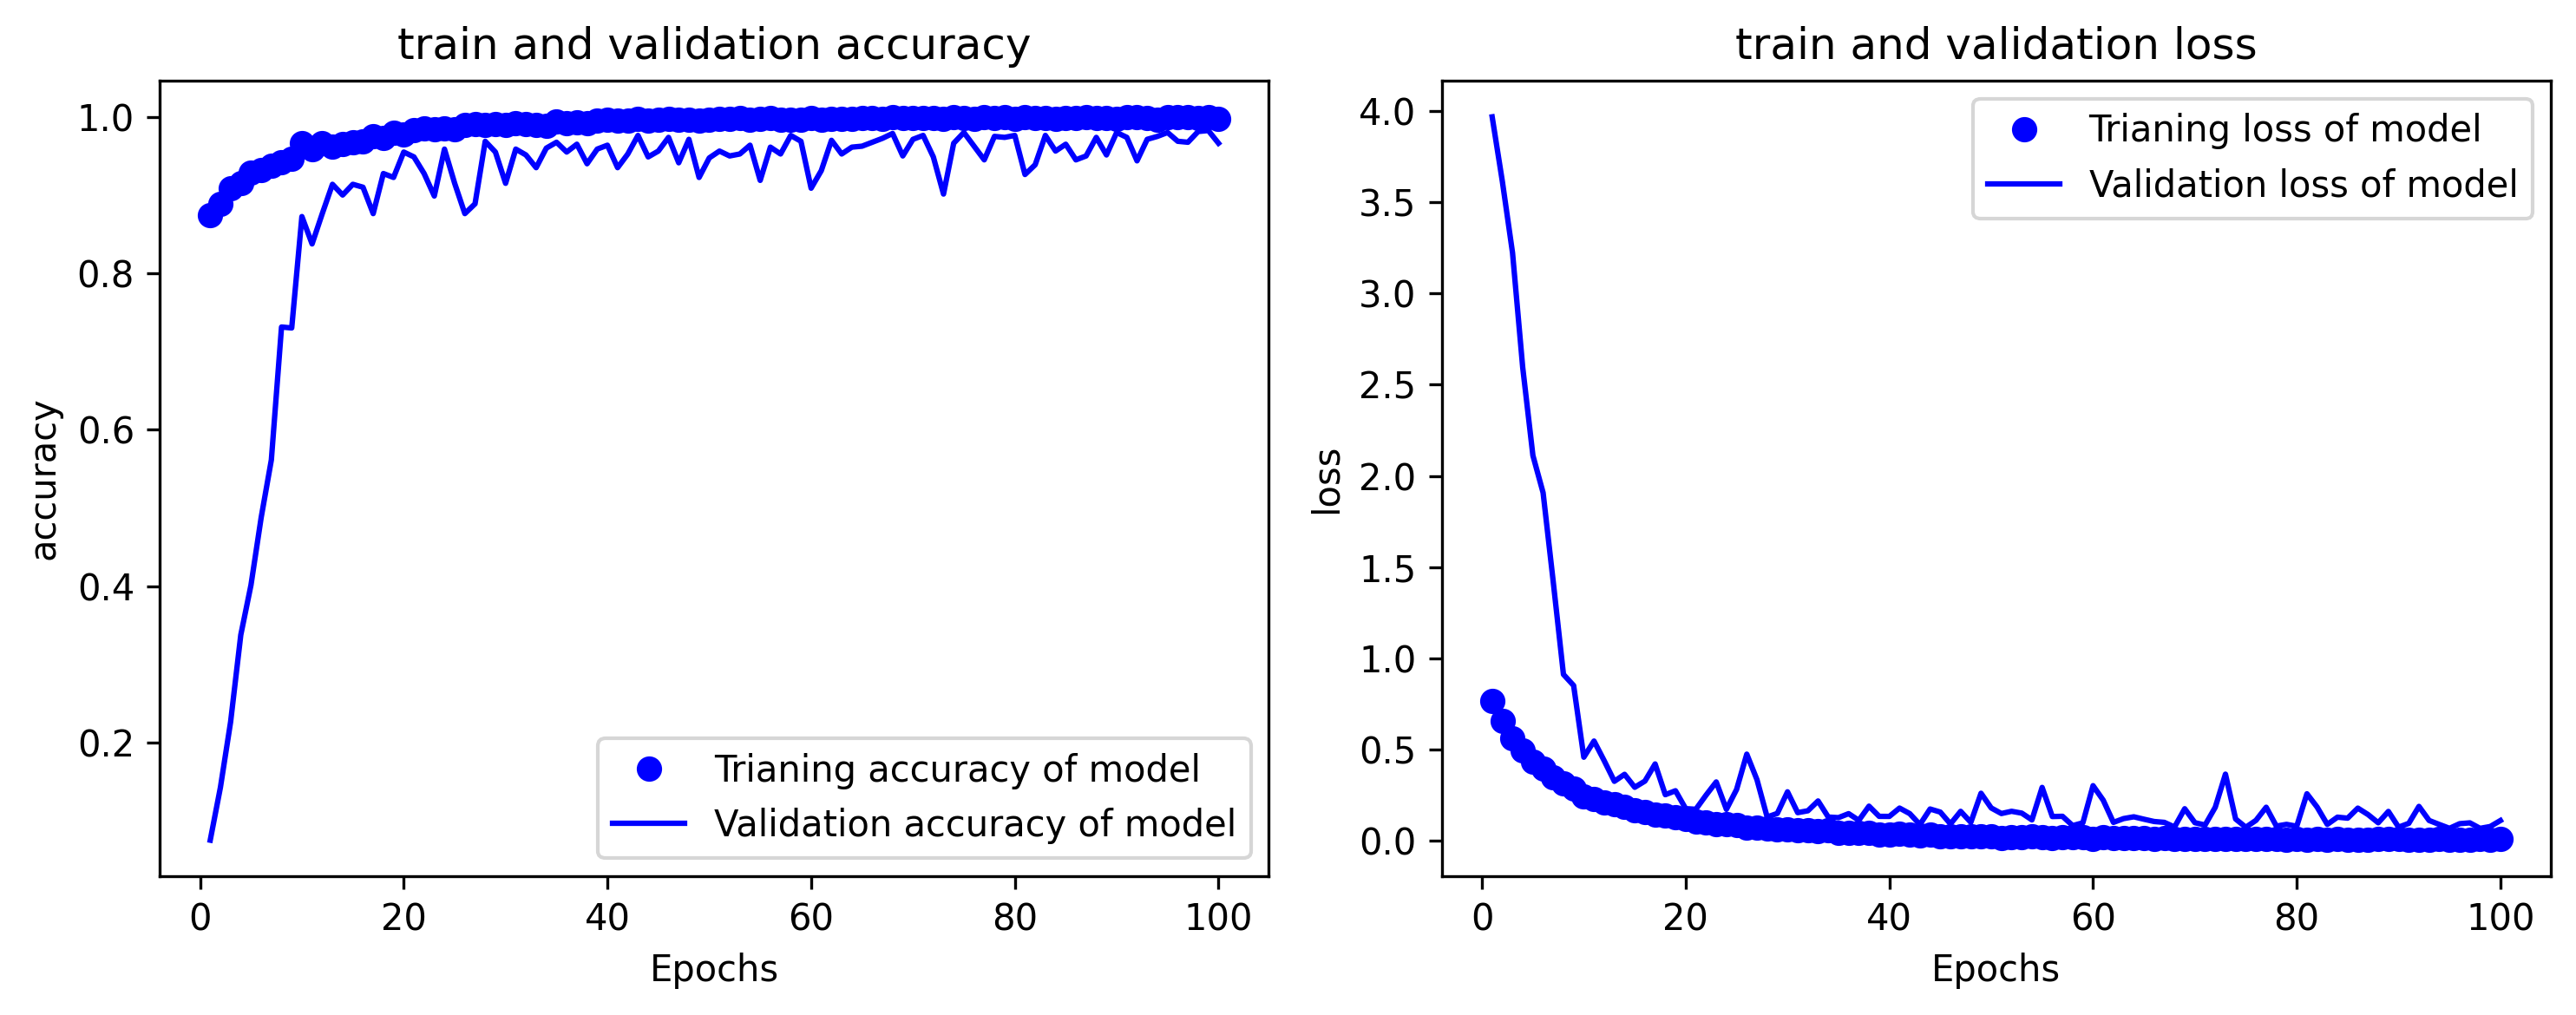

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig = plt.figure(figsize = (10, 4), facecolor = 'white', dpi = 300)

# accuracy
plt.subplot(1, 2, 1)

plt.plot(range(1, epochs + 1), acc, 'bo', label = 'Trianing accuracy of model')
plt.plot(range(1, epochs + 1), val_acc, 'b', label = 'Validation accuracy of model')
plt.title('train and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

# loss
plt.subplot(1, 2, 2)

plt.plot(range(1, epochs + 1), loss, 'bo', label = 'Trianing loss of model')
plt.plot(range(1, epochs + 1), val_loss, 'b', label = 'Validation loss of model')
plt.title('train and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.show()

**test data를 통해 모델 최종 평가 (field test)**

In [0]:
# reshaping
del test_data, test_labels

test_data = np.load(save_test_data_name + ".npy")
test_labels = np.load(save_test_labels_name + ".npy")

test_data = test_data.reshape(len(test_data), data_length, 1)
test_labels = to_categorical(test_labels)

# standarization
test_data -= mean
test_data /= std 

print('test_data.shape: {}, test_labels.shape: {}'.format(test_data.shape, test_labels.shape))

test_data.shape: (1000, 19683, 1), test_labels.shape: (1000, 50)


In [0]:
results = model.evaluate(test_data, test_labels, batch_size = batch_size)

print('test loss, test acc:', results)

13/13 [==============================] - 0s 15ms/step - loss: 0.1170 - accuracy: 0.9650
test loss, test acc: [0.11699771136045456, 0.9649999737739563]


**훈련에 참가하지 않은 test data 준비**

In [0]:
sample_rate, samples = wavfile.read(os.path.join(wav_path, "0_80.wav")) # one of test data

start = int(len(samples) - data_length) // 2
end = start + data_length

resized_samples = np.array(samples[start:end], dtype = 'float64')
resized_samples -= mean
resized_samples /= std

test_sample = resized_samples.reshape(1, len(resized_samples), 1)

print(test_sample.shape)

(1, 19683, 1)


**Activation, Channel 시각화**

In [0]:
from tensorflow.keras import models

layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)

In [0]:
activations = activation_model.predict(test_sample)

In [35]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib import colors as mcolors

layer_names = []
for layer in model.layers:
    layer_names.append(layer.name)

# show activations except last two layers (GlobalAveragePooling1D(), Dense())
for layer_name, layer_activation in zip(layer_names[:-2], activations[:-2]):
    size = layer_activation.shape[1]
    n_features = layer_activation.shape[-1]
    alpha_list = np.linspace(0, 1, n_features)

    fig = plt.figure(figsize = (10, 8), facecolor = "white", dpi = 300)
    ax = fig.gca(projection = "3d")

    xs = np.arange(size)
    zs = np.arange(n_features)

    cmap = plt.cm.get_cmap('viridis')
    verts = []
    
    for z in zs:
        ys = layer_activation[0, :, z]
        verts.append(list(zip(xs, ys)))

    poly = PolyCollection(verts, facecolors = [cmap(a) for a in alpha_list])
    poly.set_alpha(0.7)

    ax.add_collection3d(poly, zs = zs, zdir = "y")

    ax.set_xlabel('activations')    
    ax.set_ylabel('channels')
    ax.set_zlabel('amplitude')

    ax.set_xlim3d(-1 ,size)
    ax.set_ylim3d(-1, n_features)
    ax.set_zlim3d(np.min(layer_activation[0, :, :]), np.max(layer_activation[0, :, :]))

    plt.title(layer_name)
    plt.tight_layout()
    
    plt.savefig(layer_name + ".png")

Output hidden; open in https://colab.research.google.com to view.

![](./20200407/conv1d.png)
![](./20200407/max_pooling.png)
![](./20200407/batch_normalization.png)

![](./20200407/conv1d_1.png)
![](./20200407/max_pooling_1.png)
![](./20200407/batch_normalization_1.png)

![](./20200407/conv1d_2.png)
![](./20200407/max_pooling_2.png)
![](./20200407/batch_normalization_2.png)

![](./20200407/conv1d_2.png)
![](./20200407/max_pooling_2.png)
![](./20200407/batch_normalization_2.png)